# Desarrollo de un sistema de diagnóstico de enfermedades en hojas de tomate mediante PlantCV y modelos de aprendizaje profundo

La detección temprana de enfermedades en cultivos es vital para la agricultura sostenible. Utilizando PlantCV (https://plantcv.readthedocs.io/), una biblioteca enfocada en la visión por computadora para plantas, junto con TensorFlow o PyTorch, el alumno se encargará de crear modelos de clasificación multiclase robustos. Estos modelos tendrán como objetivo identificar 10 distintas enfermedades y una clase de salud en hojas de tomate. Para el entrenamiento y evaluación, se usará el Tomato Leaves Dataset de Kaggle (https://www.kaggle.com/datasets/ashishmotwani/tomato), que contiene más de 20,000 imágenes recogidas en entornos de laboratorio e in situ. Dada la naturaleza práctica de la aplicación, se buscará desarrollar un modelo lo suficientemente eficiente como para poder ser implementado en aplicaciones móviles, permitiendo diagnósticos ágiles y efectivos en el campo.

## Carga de la data

Debido a que solo existe data para train y validacion, se procede a separar un porcentaje para hacer un test final.

In [2]:
from src.utils.data_distribution import create_test_set

create_test_set("./data/train", "./data/test", percentage=10)

Se movió el 10% de imágenes de train a test correctamente.


Ya que existen nombres de archivos muy extensos es recomendable renombrarlos a una cantidad de caracteres mas manejables

In [1]:
from src.utils.rename_files import rename_images_in_directory
base_directory = "data"
rename_images_in_directory(base_directory)

Renombrando imágenes en: data\train\Bacterial_spot
Renombrando imágenes en: data\train\Early_blight
Renombrando imágenes en: data\train\healthy
Renombrando imágenes en: data\train\Late_blight
Renombrando imágenes en: data\train\Leaf_Mold
Renombrando imágenes en: data\train\powdery_mildew
Renombrando imágenes en: data\train\Septoria_leaf_spot
Renombrando imágenes en: data\train\Spider_mites Two-spotted_spider_mite
Renombrando imágenes en: data\train\Target_Spot
Renombrando imágenes en: data\train\Tomato_mosaic_virus
Renombrando imágenes en: data\train\Tomato_Yellow_Leaf_Curl_Virus
Renombrando imágenes en: data\valid\Bacterial_spot
Renombrando imágenes en: data\valid\Early_blight
Renombrando imágenes en: data\valid\healthy
Renombrando imágenes en: data\valid\Late_blight
Renombrando imágenes en: data\valid\Leaf_Mold
Renombrando imágenes en: data\valid\powdery_mildew
Renombrando imágenes en: data\valid\Septoria_leaf_spot
Renombrando imágenes en: data\valid\Spider_mites Two-spotted_spider_m

In [4]:
# codigo para cargar la data y prepararla
from src.utils.data_loader import get_data_loaders

data_dir = "data"
train_loader, valid_loader, test_loader, class_names = get_data_loaders(data_dir)

print(f"Clases detectadas: {class_names}")


✅ Carpeta 'test' detectada. Se usará como conjunto de prueba.
Clases detectadas: ['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'Spider_mites Two-spotted_spider_mite', 'Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_mosaic_virus', 'healthy', 'powdery_mildew']


In [2]:
print(f"Número total de imágenes en train_loader: {len(train_loader.dataset)}")
print(f"Número total de imágenes en valid_loader: {len(valid_loader.dataset)}")
print(f"Número total de imágenes en test_loader: {len(test_loader.dataset)}")


Número total de imágenes en train_loader: 20944
Número total de imágenes en valid_loader: 2327
Número total de imágenes en test_loader: 2580


## Exploracion de los datos

In [3]:
from src.utils.data_distribution import dataset_summary
dataset_summary(train_loader.dataset, valid_loader.dataset, test_loader.dataset)


Resumen de imágenes por clase:
----------------------------------------
📌 Conjunto de Entrenamiento: 20944 imágenes en total
  Bacterial_spot: 2269 imágenes
  Early_blight: 1984 imágenes
  Late_blight: 2516 imágenes
  Leaf_Mold: 2255 imágenes
  Septoria_leaf_spot: 2336 imágenes
  Spider_mites Two-spotted_spider_mite: 1431 imágenes
  Target_Spot: 1464 imágenes
  Tomato_Yellow_Leaf_Curl_Virus: 1639 imágenes
  Tomato_mosaic_virus: 1766 imágenes
  healthy: 2469 imágenes
  powdery_mildew: 815 imágenes

📌 Conjunto de Validación: 2327 imágenes en total
  Bacterial_spot: 275 imágenes
  Early_blight: 226 imágenes
  Late_blight: 286 imágenes
  Leaf_Mold: 224 imágenes
  Septoria_leaf_spot: 258 imágenes
  Spider_mites Two-spotted_spider_mite: 142 imágenes
  Target_Spot: 181 imágenes
  Tomato_Yellow_Leaf_Curl_Virus: 197 imágenes
  Tomato_mosaic_virus: 172 imágenes
  healthy: 277 imágenes
  powdery_mildew: 89 imágenes

📌 Conjunto de Pruebas: 2580 imágenes en total
  Bacterial_spot: 282 imágenes
  E

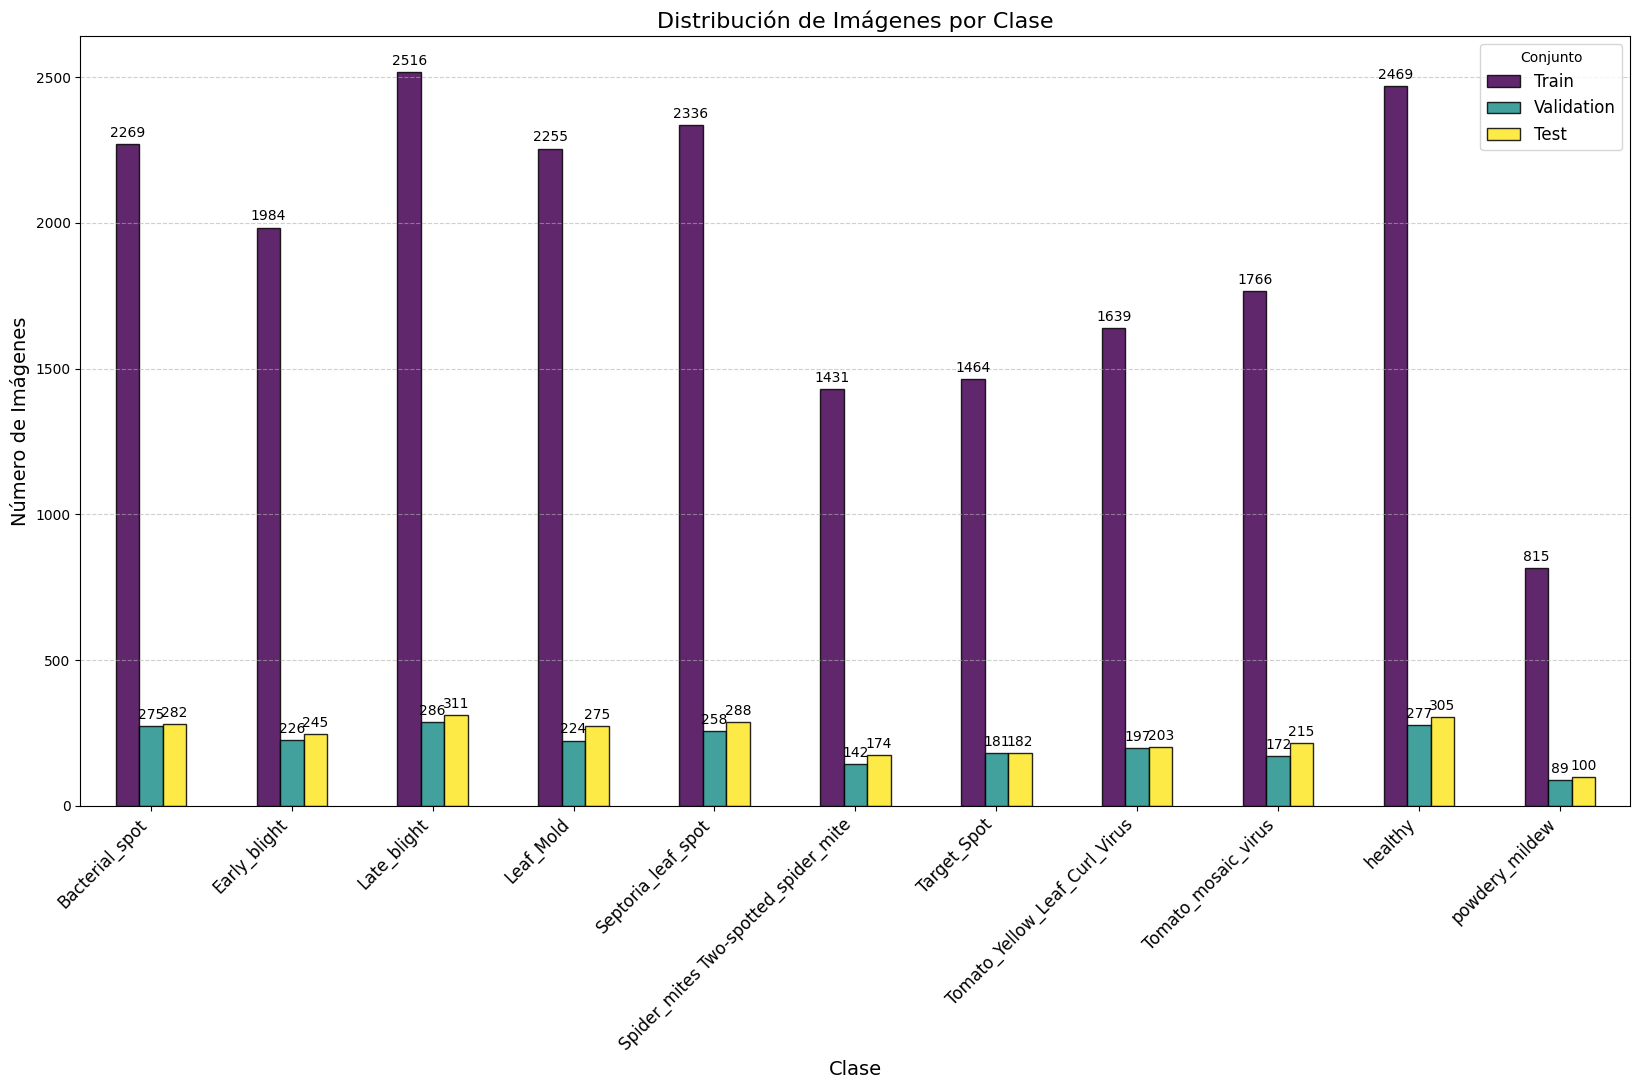

In [4]:
# codigo para explorar caracteristicas escenciales, con plantCV y demas librerias
# para ver tamanos, balance de train y validacion, separar un poco para el test
from src.utils.data_distribution import plot_class_distribution

plot_class_distribution(train_loader, valid_loader, test_loader, class_names)

## Modelos de clasificacion multiclases

In [5]:
!nvidia-smi

Fri Feb 14 15:57:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.36                 Driver Version: 566.36         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   47C    P8              4W /   35W |     471MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
#pip install torch==2.1.0+cu121 torchvision==0.16.0+cu121 --index-url https://download.pytorch.org/whl/cu121 --timeout 1000 --retries 10
import torch

if torch.cuda.is_available():
    device_count = torch.cuda.device_count()
    print(f"{device_count} GPU(s) available:")
    for i in range(device_count):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No CUDA compatible GPU detected.")


1 GPU(s) available:
GPU 0: NVIDIA GeForce RTX 4060 Laptop GPU


In [7]:
# Se crean los modelos y se los entrenan
from src.models.model import baseLineModel

# Número de clases detectadas en el dataset
num_classes = len(class_names)

# Inicializar el modelo
model = baseLineModel(num_classes)
print(model)


baseLineModel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=11, bias=True)
)


In [13]:
def reset_weights(m):
    if hasattr(m, "reset_parameters"):
        m.reset_parameters()

In [14]:
from src.models.train import train_model

model.apply(reset_weights)

# Definir hiperparámetros
num_epochs = 10
learning_rate = 0.001

# Entrenar el modelo
trained_model, history1 = train_model(model, train_loader, valid_loader, num_epochs, learning_rate)

📌 Entrenando en: cuda
Epoch 1/10 - Train Loss: 1.6231 - Train Accuracy: 42.19% - Valid Loss: 1.2740 - Valid Accuracy: 55.18%
Epoch 2/10 - Train Loss: 1.0924 - Train Accuracy: 61.11% - Valid Loss: 1.2219 - Valid Accuracy: 56.55%
Epoch 3/10 - Train Loss: 0.7058 - Train Accuracy: 75.31% - Valid Loss: 1.2314 - Valid Accuracy: 58.79%
Epoch 4/10 - Train Loss: 0.3351 - Train Accuracy: 88.82% - Valid Loss: 1.5845 - Valid Accuracy: 59.30%
Epoch 5/10 - Train Loss: 0.1455 - Train Accuracy: 95.36% - Valid Loss: 2.1543 - Valid Accuracy: 59.43%
Epoch 6/10 - Train Loss: 0.0988 - Train Accuracy: 96.84% - Valid Loss: 2.5176 - Valid Accuracy: 60.03%
Epoch 7/10 - Train Loss: 0.0695 - Train Accuracy: 97.76% - Valid Loss: 2.7047 - Valid Accuracy: 58.23%
Epoch 8/10 - Train Loss: 0.0651 - Train Accuracy: 97.95% - Valid Loss: 2.8109 - Valid Accuracy: 59.13%
Epoch 9/10 - Train Loss: 0.0503 - Train Accuracy: 98.41% - Valid Loss: 3.0606 - Valid Accuracy: 58.79%
Epoch 10/10 - Train Loss: 0.0475 - Train Accuracy: 

Se guardan los pesos de este modelo para usarlo en las proximas predicciones

In [ ]:
torch.save(trained_model.state_dict(), "base_line.pth")

## Comparacion de los mejores modelos obtenidos

In [15]:
# Se compara los modelos obtenidos y se decide por el mejor
from src.models.evaluate import evaluate_model
test_loss, test_acc = evaluate_model(trained_model, test_loader)


Test Loss: 3.3008 - Test Accuracy: 57.56%


## Predicciones con el mejor modelo para este caso

En caso que se quiera usar un modelo ya entrenado previamente

In [ ]:
import torch
from src.models.model import baseLineModel  # Importa la arquitectura de tu modelo

num_classes = len(class_names)

# Inicializar el modelo
trained_model = baseLineModel(num_classes)

# Cargar los pesos entrenados
trained_model.load_state_dict(torch.load("base_line.pth"))

# Poner el modelo en modo evaluación
trained_model.eval()

print("Modelo cargado exitosamente.")

Modelo cargado exitosamente.


In [6]:
#Se crea una clase para hacer la prediccion en base a una imagen nueva
from src.models.predict import predict_image
predicted_class, confidence = predict_image("./data/test/Late_blight/test_late_blight_1.JPG", trained_model, class_names)
print(f"La enfermedad detectada es: {predicted_class} con una probabilidad de {confidence:.2%}")

La enfermedad detectada es: Tomato_mosaic_virus con una probabilidad de 66.17%
